# Introduction
In this project, I have developed a sequence-to-sequence neural network to translate English<->Hindi.

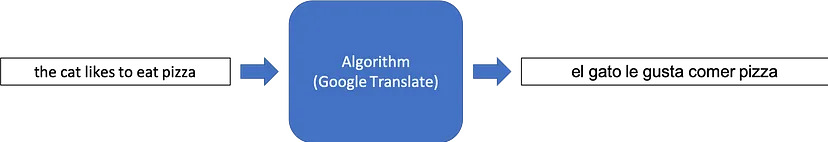

**What is sequence-to-sequence learning?**

* Sequence-to-sequence learning (Seq2Seq) is about training models to convert sequences from one domain (e.g. sentences in English) to sequences in another domain (e.g. the same sentences translated to French).

* This is made possible by the simple but powerful idea of the sequence to sequence network, in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence.

* There are multiple ways to handle this task, either using RNNs or using 1D convnets. Here we will focus on RNNs.

**The general case: sequence-to-sequence**

* In the general case, input sequences and output sequences have different lengths (e.g. machine translation) and the entire input sequence is required in order to start predicting the target. This requires a more advanced setup, which is what commonly refer to when mentioning "sequence to sequence models".

**Here's how it works:**

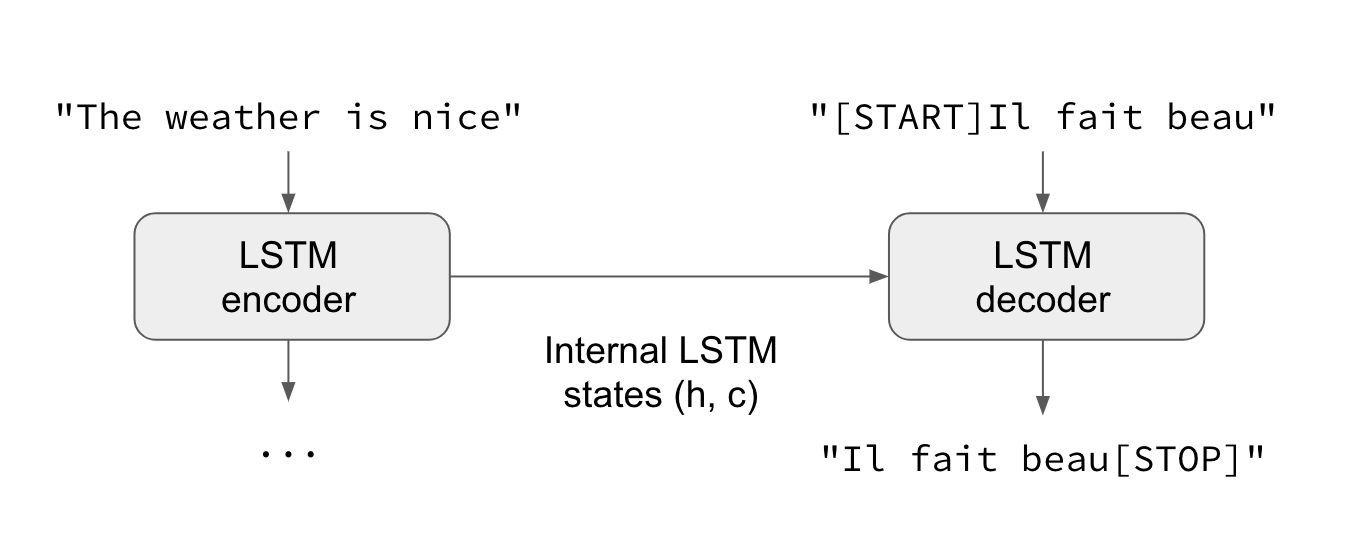

1. A RNN layer (or stack thereof) acts as "encoder": it processes the input sequence and returns its own internal state. Note that the outputs of the encoder RNN, only recovering the state. This state will serve as the "context", or "conditioning", of the decoder in the next step.

2. Another RNN layer (or stack thereof) acts as "decoder": it is trained to predict the next characters of the target sequence, given previous characters of the target sequence.

* Specifically, it is trained to turn the target sequences into the same sequences but offset by one timestep in the future.

* Importantly, the encoder uses as initial state the state vectors from the encoder, which is how the decoder obtains information about what it is supposed to generate.

* Effectively, the decoder learns to generate targets[t+1...] given targets[...t], conditioned on the input sequence.

# In inference mode

i.e. when we want to decode unknown input sequences, we go through a slightly different process:

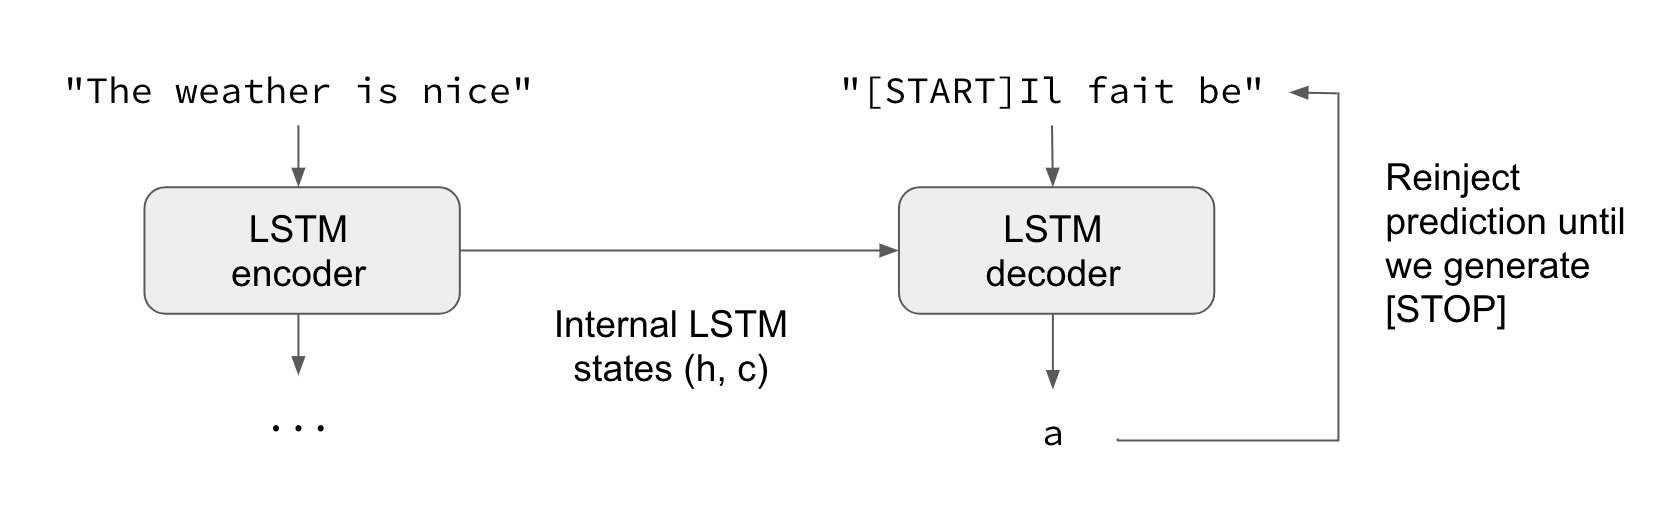

* 1) Encode the input sequence into state vectors.
* 2) Start with a target sequence of size 1 (just the start-of-sequence character).
* 3) Feed the state vectors and 1-char target sequence to the decoder to produce predictions for the next character.
* 4) Sample the next character using these predictions (we simply use argmax).
* 5) Append the sampled character to the target sequence
* 6) Repeat until we generate the end-of-sequence character or we hit the character limit.


**Building the Pipeline:**

Below is a summary of the various preprocessing and modeling steps. The high-level steps include:
* Data Preprocessing: load and examine data, cleaning, tokenization, padding.
* Word Embeddings - GloVe: Global Vectors for Word Representation
* Modeling: building, training, and testing the model.
* Prediction: generate specific translations of English to Hindi, and compare the output translations to the ground truth translations.
* Iteration: iterate on the model, experimenting with different architectures.

**Requirements:**

Libraries and Configuration Settings

In [ ]:
import os, sys
import unicodedata
import string
import re
from numpy import array, argmax, random, take
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, roc_curv
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

# keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, GRU, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from keras.utils import to_categorical

set values for different model parameters:

In [ ]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100


# Loading data files

The data used is a paired corpus of English-Hindi translation pairs.
, provided by Anki.

This dataset contains language translation pairs in the format:

**the passengers who were injured in the accident were taken to the nearest hospital', 'जिन यात्रियों को दुर्घटना मे चोट आई थी उन्हे अस्पताल ले जाया गया'**


Following code ->


*   Each line in the hin.txt file contains an English word/sentence and their corresponding Hindi translation.
* Some words might have multiple translation because of context.
*   Our first objective is to download the file hin-eng.zip and extract it to each line, and then separate the English and Hindi words/sentences into two separate arrays. These will act as our input and target sentences for training the model.

In [ ]:
# Download and prepare the dataset
!wget https://www.manythings.org/anki/hin-eng.zip
!unzip "/content/hin-eng.zip" -d "/content/dataset/"

--2023-11-09 10:40:11--  https://www.manythings.org/anki/hin-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135012 (132K) [application/zip]
Saving to: ‘hin-eng.zip’

hin-eng.zip         100%[===================>] 131.85K   802KB/s    in 0.2s    

2023-11-09 10:40:11 (802 KB/s) - ‘hin-eng.zip’ saved [135012/135012]

Archive:  /content/hin-eng.zip
  inflating: /content/dataset/hin.txt  
  inflating: /content/dataset/_about.txt  


# Data handling

In [ ]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

data = read_text("/content/dataset/hin.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [ ]:
deu_eng

array([['Wow!', 'वाह!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #6179147 (fastrizwaan)'],
       ['Duck!', 'झुको!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #6179041 (fastrizwaan)'],
       ['Duck!', 'बतख़!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #6179042 (fastrizwaan)'],
       ...,
       ['Democracy is the worst form of government, except all the others that have been tried.',
        'लोकतंत्र सरकार का सबसे घिनौना रूप है, अगर बाकी सारी तरह की सरकारों को अंदेखा किया जाए तो।',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1550 (Zifre) & #480226 (minshirui)'],
       ['If my boy had not been killed in the traffic accident, he would be a college student now.',
        'अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया होता, तो वह अभी कॉलेज जा रहा होता।',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #399492 (blay_paul) & #515450 (minshirui)'],
       ["When I was a kid, touching bugs didn

# Data Preprocessing

After downloading and initial exploration of the dataset, here are the steps we’ll take to prepare the data:
1. Clean the sentences by removing special characters & space except (a-z, A-Z, “.”, “?”, “!”, “,”)
2. Creating a space between a word and the punctuation following it.
3. Add a start and end token to each sentence.
4. Pad each sentence to a maximum length.
5. Return word pairs in the format: [ENGLISH, Hindi]

In [ ]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

removetable = str.maketrans('', '', '।')
deu_eng[:,0]=[s.translate(removetable) for s in deu_eng[:,0]]
deu_eng[:,1]=[s.translate(removetable) for s in deu_eng[:,1]]

# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

# Remove 3rd/matching element from nested list-
deu_eng = [[y for y in x if not re.search(r'^CC-BY', y)] for x in deu_eng]

# convert list to Numpy array
deu_eng = array(deu_eng)

print("num samples in data:", len(deu_eng))
deu_eng[-10:]
# for _ in data:
#   print(" ".join(map(str, _)))

num samples in data: 2979


array([['father kept in touch with us by mail and telephone while he was overseas',
        'जब पिताजी विदेश में थे वे हमारे साथ चिट्ठी और फ़ोन से सम्पर्क करते थे'],
       ['mother teresa was a catholic nun who lived and worked in calcutta india',
        'मदर टेरेसा एक कैथोलिक नन थीं जो कलकत्ता में रहतीं और काम करतीं थीं'],
       ['from my point of view australia is one of the best countries in the world',
        'मेरे नज़रिए से ऑस्ट्रेलिया विश्व के सर्वश्रेष्ठ देशों में से एक है'],
       ['in 1951 sister teresa was sent to calcutta then the largest city in india',
        '१९५१ में सिस्टर टेरेसा को कलकत्ता भेजा गया था जो उस समय भारत का सबसे बड़ा शहर था'],
       ['mother teresa used the prize money for her work in india and around the world',
        'मदर टेरेसा को जो इनाम में पैसे मिले उन्होंने उन पैसों को भारत और विदोश दोनों में अपने काम में लगाया'],
       ['if you go to that supermarket you can buy most things you use in your daily life',
        'उस सूपरमार्केट में तुम लगभग 

# Create source and target sequences



In [ ]:
# Adding a start and an end token to the sentence so that the model know when to start and stop predicting.

input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in deu_eng:
    count += 1
    # print(line)

    input_sentence, output = [x.split(',')[0] for x in line]
    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 2979
num samples output: 2979
num samples output input: 2979


# Tokenize the data

Once, the sentences are splitted and special tokens are added, the process of tokenization is carried out using the Tokenizer class from the keras.preprocessing.text module.

This step will convert both the input and the output sentences into integer sequences of fixed length.

Steps:
* The Tokenizer object is initialized and fit to the text data.
* The texts are then tokenized, meaning that each word is assigned a unique number.
* The resulting sequences are then padded to make all of them of equal length.

In [ ]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print(word2idx_inputs)
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

{'the': 1, 'i': 2, 'to': 3, 'you': 4, 'a': 5, 'is': 6, 'he': 7, 'of': 8, 'in': 9, 'it': 10, 'my': 11, 'do': 12, 'me': 13, 'have': 14, 'this': 15, 'that': 16, 'was': 17, 'she': 18, 'for': 19, 'are': 20, 'his': 21, 'what': 22, 'your': 23, 'tom': 24, 'dont': 25, 'we': 26, 'on': 27, 'at': 28, 'will': 29, 'like': 30, 'him': 31, 'her': 32, 'go': 33, 'not': 34, 'be': 35, 'im': 36, 'with': 37, 'how': 38, 'know': 39, 'can': 40, 'has': 41, 'and': 42, 'up': 43, 'its': 44, 'there': 45, 'all': 46, 'time': 47, 'very': 48, 'they': 49, 'come': 50, 'want': 51, 'as': 52, 'did': 53, 'here': 54, 'from': 55, 'had': 56, 'please': 57, 'when': 58, 'were': 59, 'an': 60, 'cant': 61, 'by': 62, 'out': 63, 'about': 64, 'ill': 65, 'one': 66, 'going': 67, 'no': 68, 'get': 69, 'didnt': 70, 'been': 71, 'am': 72, 'take': 73, 'would': 74, 'if': 75, 'father': 76, 'day': 77, 'us': 78, 'book': 79, 'now': 80, 'see': 81, 'money': 82, 'but': 83, 'make': 84, 'help': 85, 'today': 86, 'long': 87, 'two': 88, 'live': 89, 'tomorrow

Similarly, the output sentences can also be tokenized in the same way as shown below:

In [ ]:
# prepare Hindi tokenizer
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)

output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
# print(word2idx_outputs)
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 2906
Length of longest sentence in the output: 26


Let's now randomly print a sentence from the input_sentences[], output_sentences[], and output_sentences_inputs[] lists:

In [ ]:
print(input_sentences[2912])
print(output_sentences[2912])
print(output_sentences_inputs[2912])

there is nothing on earth that is not affected by the sun
विष्व में ऐसी कोई भी वस्तु नहीं है जिसपर सूर्य का प्रभाव न पड़ता हो <eos>
<sos> विष्व में ऐसी कोई भी वस्तु नहीं है जिसपर सूर्य का प्रभाव न पड़ता हो


* You can see the original sentence, i.e. There is nothing on earth that is not affected by the sun.
its corresponding translation in the output, i.e विष्व में ऐसी कोई भी वस्तु नहीं है जिसपर सूर्य का प्रभाव न पड़ता हो। <end>

* Notice, here we have the <eos> token at the end of the sentence. Similarly, for the input to the decoder, we have -> <start>विष्व में ऐसी कोई भी वस्तु नहीं है जिसपर सूर्य का प्रभाव न पड़ता हो।

# Padding:

Next, we need to pad the input. The reason behind padding the input and the output is that text sentences can be of varying length, however LSTM (the algorithm that we are going to train our model) expects input instances with the same length. Therefore, we need to convert our sentences into fixed-length vectors. One way to do this is via padding is using **Keras's pad_sequences function.**


In addition to tokenization and integer conversion, the word_index attribute of the Tokenizer class returns a word-to-index dictionary where words are the keys and the corresponding integers are the values.

The script above also prints the number of unique words in the dictionary and the length of the longest sentence in the input:

In [ ]:
# input sentence padding
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)

The script above prints the shape of the padded input sentences. The padded integer sequence for the sentence at index 172 is also printed. Here is the output:

In [ ]:
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[2912]:", encoder_input_sequences[2912])

encoder_input_sequences.shape: (2979, 22)
encoder_input_sequences[2912]: [   0    0    0    0    0    0    0    0    0    0   45    6  129   27
  593   16    6   34 1296   62    1  875]


Since there are 2979 sentences in the input and each input sentence is of length 22, the shape of the input is now (2979, 22).

In [ ]:
# In the same way, the decoder outputs and the decoder inputs are padded as follows:

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')

print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[2912]:", decoder_input_sequences[2912])

decoder_input_sequences.shape: (2979, 26)
decoder_input_sequences[2912]: [   2 1402    5  375   56   36 2816    4    3 1414 2817   19 2818  123
  382   14    0    0    0    0    0    0    0    0    0    0]


The sentence at index 172 of the decoder input is <sos> je suis malade.. If you print the corresponding integers from the word2idx_outputs dictionary, you should see 2, 3, 6, and 188 printed on the console, as shown here:

**Padding at the start or at the end?**

It is further important to mention that in the case of the decoder, the post-padding is applied, which means that zeros are appended at the end of the sentence.
* In the encoder, zeros were padded at the beginning. The reason behind this approach is that encoder output is based on the words occurring at the end of the sentence,
* therefore the original words were kept at the end of the sentence and zeros were padded at the beginning.
* On the other hand, in the case of the decoder, the processing starts from the beginning of a sentence, and therefore post-padding is performed on the decoder inputs and outputs

# Word Embeddings

We want word embeddings to capture the context of the paragraph or previous sentences along with capturing the semantic and syntactic properties and similarities of the same.

**But we already converted our words into integers. So what's the difference between integer representation and word embeddings?**

There are two main differences between single integer representation and word embeddings:
* With integer representation, a word is represented only with a single integer.
* With vector representation a word is represented by a vector of 50, 100, 200, or whatever dimensions it has

1. Hence, word embeddings capture a lot more information about words.
2. Secondly, the single-integer representation doesn't capture the relationships between different words.
3. On the contrary, word embeddings retain relationships between the words. You can either use custom word embeddings or you can use pre-trained word embeddings.

**Word Embeddings technique in NLP:**

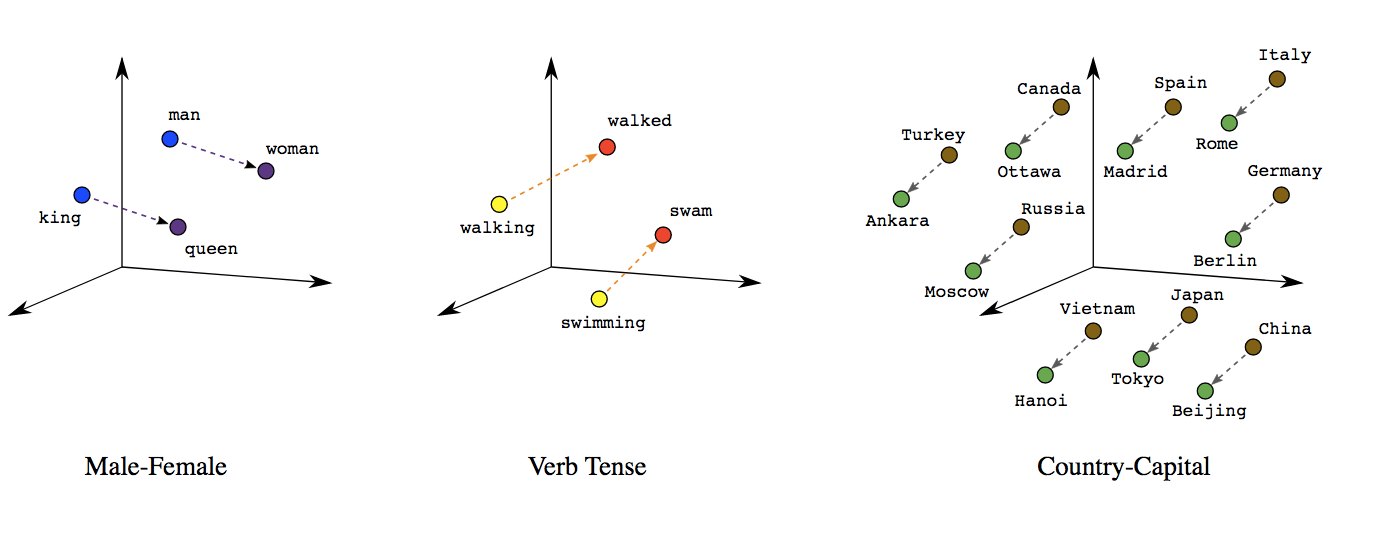

1. Term frequency-inverse document frequency (TF-IDF): This algorithm works on a statistical measure, such as The term frequency (TF) score measures the frequency of words in a particular document. In simple words, it means that the occurrence of words is counted in the documents.
* The IDF score measures the rarity of the words in the text.
* TF-IDF algorithm finds application in solving simpler natural language processing and machine learning problems.
* However, it does not capture the semantic meaning of words efficiently in a sequence.

2. Bag of words (BOW): A bag of words is one of the popular word embedding techniques of text where each value in the vector would represent the count of words in a document/sentence. In other words, it extracts features from the text. We also refer to it as vectorization.

3. Word2Vec: It was invented for training word embeddings and is based on a distributional hypothesis.

Word2Vec has two neural network-based variants: Continuous Bag of Words (CBOW) and Skip-gram.

* In this hypothesis, it uses skip-grams or a continuous bag of words (CBOW).
* These are basically shallow neural networks that have an input layer, an output layer, and a projection layer. It reconstructs the linguistic context of words by considering both the order of words in history as well as the future.
* The method involves iteration over a corpus of text to learn the association between the words. It relies on a hypothesis that the neighboring words in a text have semantic similarities with each other. It assists in mapping semantically similar words to geometrically close embedding vectors.
* It uses the cosine similarity metric to measure semantic similarity. Cosine similarity is equal to Cos(angle) where the angle is measured between the vector representation of two words/documents.
- **So if the cosine angle is one, it means that the words are overlapping.**
- **And if the cosine angle is a right angle or 90°, It means words hold no contextual similarity and are independent of each other.**

4. GloVe: Global Vector for word representation: GloVe focuses on global context to create word embeddings which gives it an edge over Word2Vec.
* In GloVe, the semantic relationship between the words is obtained using a co-occurrence matrix.
* Each value in this matrix represents the count of co-occurrence with the corresponding word in row/column.
* The core idea behind GloVe is that the word co-occurrence is the most important statistical information available for the model to ‘learn’ the word representation.
* GloVe paper used co-occurrence probability rations.
* The probability ratio is able to better distinguish relevant words (solid and gas) from irrelevant words (fashion and water) than the raw probability.
* It is also able to better discriminate between two relevant words.
* Hence in GloVe, the starting point for word vector learning is ratios of co-occurrence probabilities rather than the probabilities themselves.

5. BERT (Bidirectional encoder representations from transformers): It relies on an attention mechanism for generating high-quality world embeddings that are contextualized.
* So when the embedding goes through the training process, they are passed through each BERT layer so that its attention mechanism can capture the word associations based on the words on the left and those on the right.
* This technique can be further improved for task-specific data sets by fine-tuning the embeddings.
* It finds great application in language translation tasks.

**Here’s a final checklist for a recap:**
- Bag of words: Extracts features from the text
- TF-IDF: Information retrieval, keyword extraction
- Word2Vec: Semantic analysis task
- GloVe: Word analogy, named entity recognition tasks
- BERT: language translation, question answering system


In this project, for English sentences, i.e. the inputs, we will use the **GloVe word embeddings.** For the translated Hindi sentences in the output, we will use custom word embeddings.


In [ ]:
# download glove and unzip it in Notebook.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-11-09 10:40:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-11-09 10:40:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-11-09 10:40:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Let's create word embeddings for the inputs first.

* To do so, we need to load the GloVe word vectors into memory.
* We will then create a dictionary where words are the keys and the corresponding vectors are values, as shown below:

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split(' ')
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

We have 3523 unique words in the input (English).
- We will create a matrix, where the row number will represent the integer value for the word and the columns will correspond to the dimensions of the word.
- This matrix will contain the word embeddings for the words in our input sentences.

In [ ]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))

for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
# Let's first print the word embeddings for the word hard -> using the GloVe word embedding dictionary.
embeddings_dictionary["tom"]


array([-5.8388e-01, -4.6940e-01,  1.6855e-01, -1.6703e+00, -1.1601e-01,
        4.8738e-02, -3.4201e-01, -3.7691e-01, -9.5308e-01, -8.8260e-01,
       -1.5615e-01, -2.5286e-01, -1.7231e-01,  7.7389e-01, -2.8665e-01,
       -5.7293e-01,  4.8466e-02,  5.6796e-01, -5.1512e-01,  8.2133e-01,
        1.2387e-01,  5.1043e-01, -2.9292e-01, -4.1569e-01,  3.8172e-01,
       -3.4662e-01, -2.1170e-01, -4.9633e-01,  4.7976e-03, -2.4324e-01,
       -2.7532e-01,  5.8502e-01,  3.7118e-02, -2.8699e-02,  9.8552e-02,
       -2.7569e-01,  2.9225e-02,  3.8424e-01,  7.4656e-01,  3.4539e-01,
       -2.7420e-01, -1.1324e-02,  7.8647e-02,  5.2876e-01, -3.2349e-01,
        1.2181e-02, -9.2578e-01, -7.3945e-01,  3.7589e-01, -7.8768e-01,
       -1.6800e-01, -1.3452e-01,  2.8061e-01, -1.0463e-02,  7.1194e-01,
       -2.5907e+00, -1.6852e-01,  3.9910e-01,  4.2467e-02,  3.2477e-01,
        2.0210e-01,  4.7876e-01,  5.1855e-01, -2.7218e-02,  6.7250e-01,
       -4.4216e-01,  1.1812e+00,  1.0642e+00,  8.0151e-02,  3.71

In [ ]:
print(embedding_matrix[24])

[-5.83880007e-01 -4.69399989e-01  1.68550000e-01 -1.67030001e+00
 -1.16010003e-01  4.87379991e-02 -3.42009991e-01 -3.76910001e-01
 -9.53079998e-01 -8.82600009e-01 -1.56149998e-01 -2.52860010e-01
 -1.72309995e-01  7.73890018e-01 -2.86650002e-01 -5.72929978e-01
  4.84660007e-02  5.67960024e-01 -5.15120029e-01  8.21330011e-01
  1.23870000e-01  5.10429978e-01 -2.92919993e-01 -4.15690005e-01
  3.81720006e-01 -3.46619993e-01 -2.11700007e-01 -4.96329993e-01
  4.79760021e-03 -2.43239999e-01 -2.75319993e-01  5.85020006e-01
  3.71179990e-02 -2.86989994e-02  9.85520035e-02 -2.75689989e-01
  2.92249992e-02  3.84240001e-01  7.46559978e-01  3.45389992e-01
 -2.74199992e-01 -1.13239996e-02  7.86470026e-02  5.28760016e-01
 -3.23489994e-01  1.21809999e-02 -9.25779998e-01 -7.39449978e-01
  3.75889987e-01 -7.87679970e-01 -1.67999998e-01 -1.34519994e-01
  2.80609995e-01 -1.04630003e-02  7.11939991e-01 -2.59069991e+00
 -1.68520004e-01  3.99100006e-01  4.24670018e-02  3.24770004e-01
  2.02099994e-01  4.78760

* We can see that the values for the 24'th row in the embedding matrix are similar to the vector representation of the word "tom" in the GloVe dictionary.
* which confirms that rows in the embedding matrix represent corresponding word embeddings from the GloVe word embedding dictionary.

This word embedding matrix will be used to create the embedding layer for our LSTM model.

In [ ]:
# The following script creates the embedding layer for the input:

embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

# Build the NMT model

**Here's a summary of our process:**

* 1) Turn the sentences into 3 Numpy arrays, encoder_input_data, decoder_input_data, decoder_target_data:

* encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.

* decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containg a one-hot vectorization of the Hindi sentences.

* decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].

* 2) Train a LSTM-based Seq2Seq model to predict decoder_target_data given encoder_input_data and decoder_input_data.

* 3) Decode some sentences to check that the model is working (i.e. turn samples from encoder_input_data into corresponding samples from decoder_target_data).


Now is the time to develop our model:
1. The first thing we need to do is to define our outputs, as we know that the output will be a sequence of words.

For each input sentence, we need a corresponding output sentence. Therefore, the final shape of the output will be:
* (number of inputs, length of the output sentence, the number of words in the output)


In [ ]:
# The following script creates the empty output array:

decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [ ]:
# The following script prints the shape of the decoder:
decoder_targets_one_hot.shape

# which should be => (number of inputs, length of the output sentence, the number of words in the output)

(2979, 26, 2907)

**one-hot encoded vectors:**

* To make predictions, the final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors, since we will be using softmax activation function at the dense layer.

* To create such one-hot encoded output, the next step is to assign 1 to the column number that corresponds to the integer representation of the word

In [ ]:
for i, d in enumerate(decoder_input_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

# Encoder and decoders model:

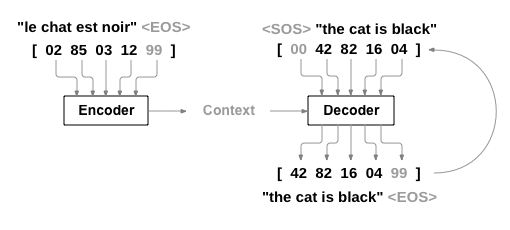

 * Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.


* The input to the encoder will be the sentence in English and the output will be the hidden state and cell state of the LSTM.

# This is our training model. It leverages three key features:

1. The return_state contructor argument, configuring a RNN layer to return a list where the first entry is the outputs and the next entries are the internal RNN states. This is used to recover the states of the encoder.

2. The inital_state call argument, specifying the initial state(s) of a RNN. This is used to pass the encoder states to the decoder as initial states.

3. The return_sequences constructor argument, configuring a RNN to return its full sequence of outputs (instead of just the last output, which the defaults behavior). This is used in the decoder.

In [ ]:
# Define an input sequence and process it.
encoder_inputs_placeholder = Input(shape=(max_input_len,))

# embedding_layer
x = embedding_layer(encoder_inputs_placeholder)

# LSTM
encoder = LSTM(LSTM_NODES, return_state=True)

# encoder
encoder_outputs, h, c = encoder(x)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [h, c]

**The next step is to define the decoder LSTM: **

- The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

The decoder will have two inputs:
1. the hidden state and cell state from the encoder,
2. the input sentence, which actually will be the output sentence with an <start> token appended at the beginning.

---



In [ ]:

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs_placeholder = Input(shape=(max_out_len,))


decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

Finally, the output from the decoder LSTM is passed through a dense layer to predict decoder outputs, as shown here:

In [ ]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# compile the model:

In [ ]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`

model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
# where,
# 1. encoder_inputs_placeholder is Input to encoder(LSTM model).
# 2. decoder_inputs_placeholder is Input to decoder_lstm & decoder_embedding.
# 3. decoder_outputs is the output from the decoder LSTM is passed through a dense layer to predict decoder outputs.

model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

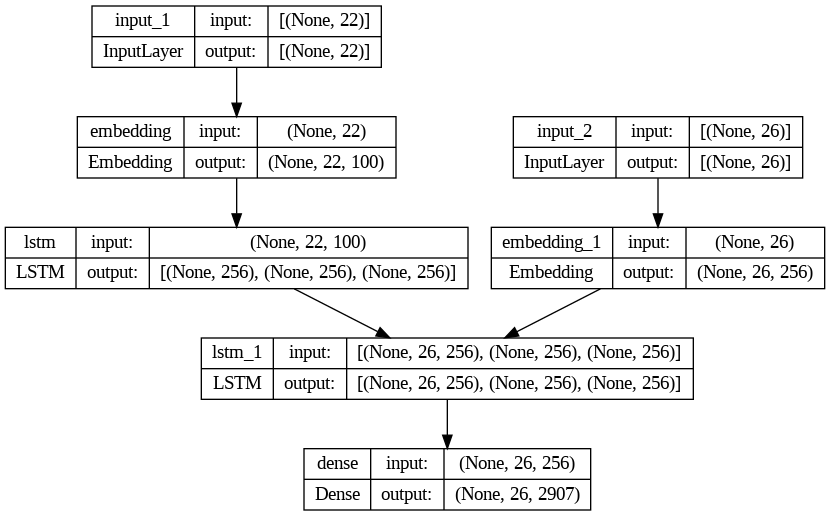

In [ ]:
# Let's plot our model to see how it looks:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

From the output, you can see that we have two types of input.
1. input_1 is the input placeholder for the encoder, which is embedded and passed through lstm layer, which basically is the encoder LSTM.

2. There are three outputs from the lstm_1 layer: the output, the hidden layer and the cell state. However, only the cell state and the hidden state are passed to the decoder.

* Here the lstm_1 layer is the decoder LSTM:

1. The input_2 contains the output sentences with <sos> token appended at the start.
2. The input_2 is also passed through an embedding layer and is used as input to the decoder LSTM, lstm_1.

* Finally, the output from the decoder LSTM is passed through the dense layer to make predictions.

**ModelCheckpoint callback**

Callback to save the Keras model or model weights at some frequency.

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/translation/lstm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,)


# Model training

We train our model, while monitoring the loss on a held-out set of 20% of the samples.

In [ ]:
# The next step is to train the model using the fit() method:

history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    callbacks=[model_checkpoint_callback],
)


Epoch 1/20
42/42 [==============================] - 28s 562ms/step - loss: 2.7028 - accuracy: 0.7317 - val_loss: 3.0918 - val_accuracy: 0.5768
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 23s 551ms/step - loss: 1.6832 - accuracy: 0.7561 - val_loss: 3.2049 - val_accuracy: 0.5789
Epoch 3/20
42/42 [==============================] - 23s 551ms/step - loss: 1.5780 - accuracy: 0.7598 - val_loss: 2.7954 - val_accuracy: 0.5842
Epoch 4/20
42/42 [==============================] - 24s 578ms/step - loss: 1.5002 - accuracy: 0.7664 - val_loss: 2.7681 - val_accuracy: 0.5851
Epoch 5/20
42/42 [==============================] - 22s 527ms/step - loss: 1.4609 - accuracy: 0.7730 - val_loss: 2.7305 - val_accuracy: 0.5964
Epoch 6/20
42/42 [==============================] - 23s 542ms/step - loss: 1.4389 - accuracy: 0.7761 - val_loss: 2.7013 - val_accuracy: 0.5999
Epoch 7/20
42/42 [==============================] - 24s 562ms/step - loss: 1.4149 - accuracy: 0.7782 - val_loss: 2.6610 - val_accuracy: 0.6078
Epoch 8/20
42/42 [==============================] - 24s 563ms/step - loss: 1.3796 - accuracy: 0.7828 - val_loss: 2.6168 - val_accuracy: 0.6111
Epoch 9/20

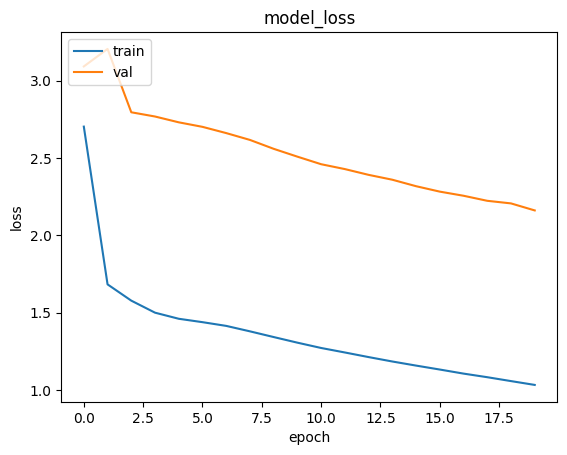

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

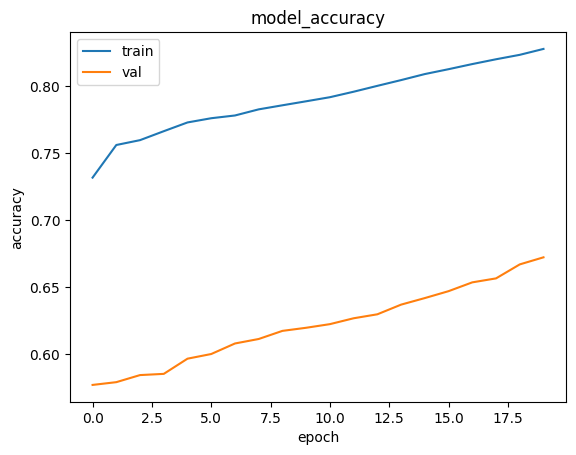

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model is trained for 20 epochs, and After 20 epochs, I got training accuracy of 83% and the validation accuracy of 67% which shows that the model is performing optimally.